# Analysis - exp42

- Tune attempt 2 for MCTS. Same params as exp41 but the root tree is cached and reused until a better one is found. Light policy improvement.

In [1]:
import os
import csv
import numpy as np
import torch as th

from glob import glob
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style('ticks')

matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('axes', titlesize=16)

from notebook_helpers import load_params
from notebook_helpers import load_monitored
from notebook_helpers import join_monitored
from notebook_helpers import score_summary

def load_data(path, run_index=(0, 20)):
    runs = range(run_index[0], run_index[1]+1)
    exps = []
    for r in runs:
        file = os.path.join(path, "run_{}_monitor.csv".format(int(r)))
        try:
            mon = load_monitored(file)
        except FileNotFoundError:
            mon = None
        exps.append(mon)
    return exps

# Load data

In [2]:
path = "/Users/qualia/Code/azad/data/wythoff/exp42/"
exp_42 = load_data(path, run_index=(0, 199))
grid_42 = load_params(os.path.join(path, "grid.csv"))

In [3]:
print(grid_42.keys())

dict_keys(['row_code', 'c', 'num_simulations'])


In [4]:
print(len(grid_42['row_code']))
print(len(exp_42))

200
200


In [5]:
pprint(exp_42[0].keys())
pprint(len(exp_42[0]['loss']))
pprint(exp_42[0]['score'][:20])

dict_keys(['file', 'episode', 'score'])
0
[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05555555555555555,
 0.05,
 0.05,
 0.047619047619047616,
 0.047619047619047616]


# Plots

## c, exploration constant

Curves for each c. We tabulate over all other metaparams.

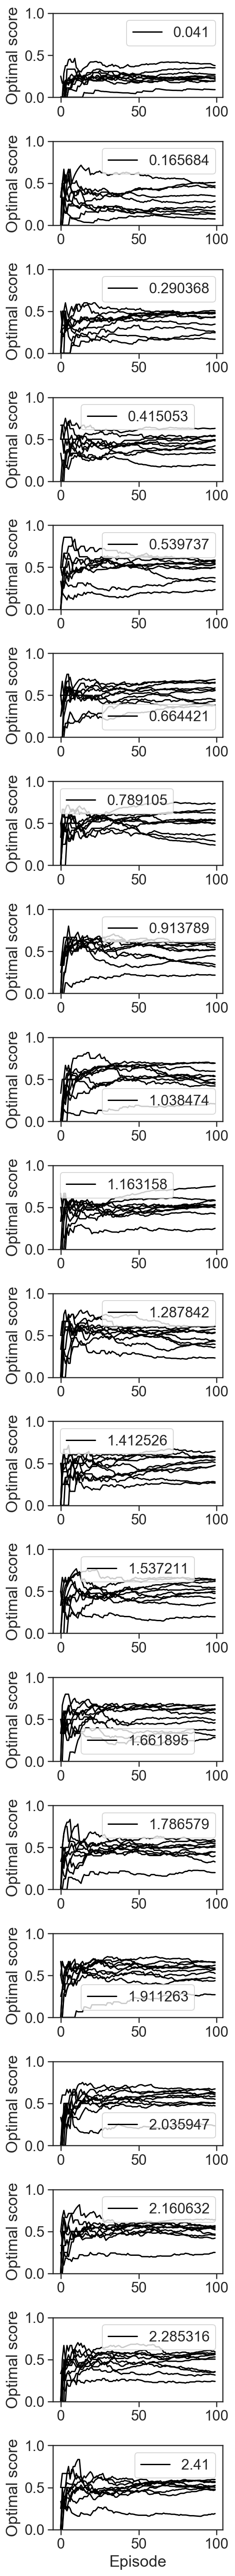

In [6]:
plt.figure(figsize=(4, 40.5))

cs = sorted(set(grid_42['c']))
for n, c in enumerate(cs):
    plt.subplot(len(cs), 1, n+1)
    index = c == np.asarray(grid_42['c'])
    index = np.arange(0,len(index))[index]
    first = True
    for r, mon in enumerate(exp_42):
        if r in index:
            if mon is not None:
                _ = plt.plot(mon['episode'], mon['score'], label=c, color='black')
                _ = plt.ylim(0, 1)
                _ = plt.ylabel("Optimal score")
                _ = plt.tight_layout()
                if first:
                    plt.legend()
                    first = False
                                    
_ = plt.xlabel("Episode")

Histograms of final values

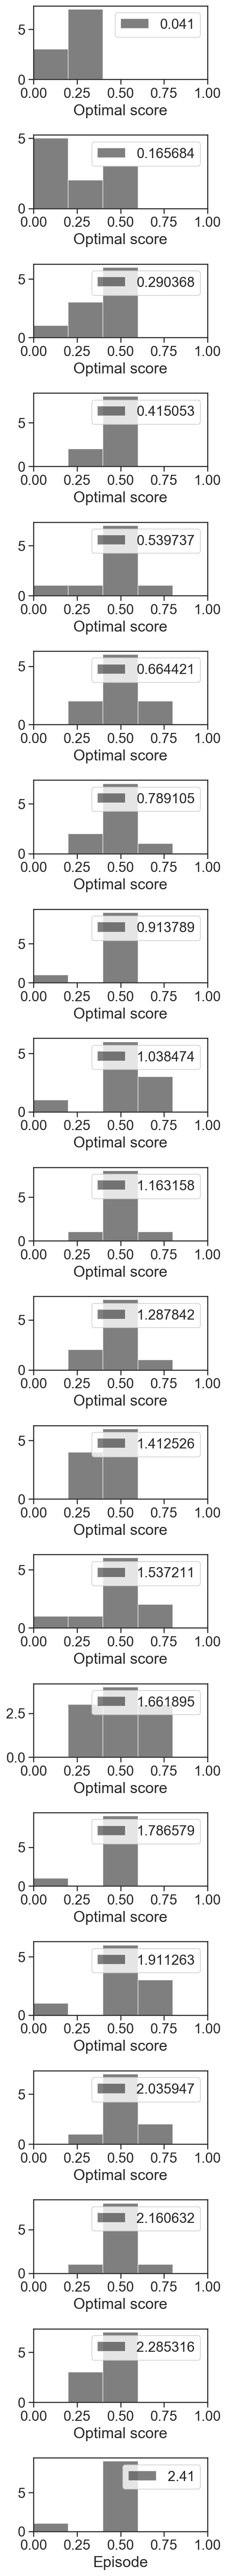

In [15]:
plt.figure(figsize=(4, 42.5))

sims = sorted(set(grid_42['c']))
for n, sim in enumerate(sims):
    plt.subplot(len(sims), 1, n+1)
    index = sim == np.asarray(grid_42['c'])
    index = np.arange(0,len(index))[index]
    first = True
    data = []
    for r, mon in enumerate(exp_42):
        if r in index:
            if mon is not None:
                data.append(np.mean(mon['score']))                
    _ = plt.hist(data, label=sim, alpha=0.5, color="black", bins=5, range=(0,1))        
    _ = plt.xlabel("Optimal score")
    _ = plt.xlim(0,1)
    _ = plt.tight_layout()
    plt.legend()
                                    
_ = plt.xlabel("Episode")

## num_simulations

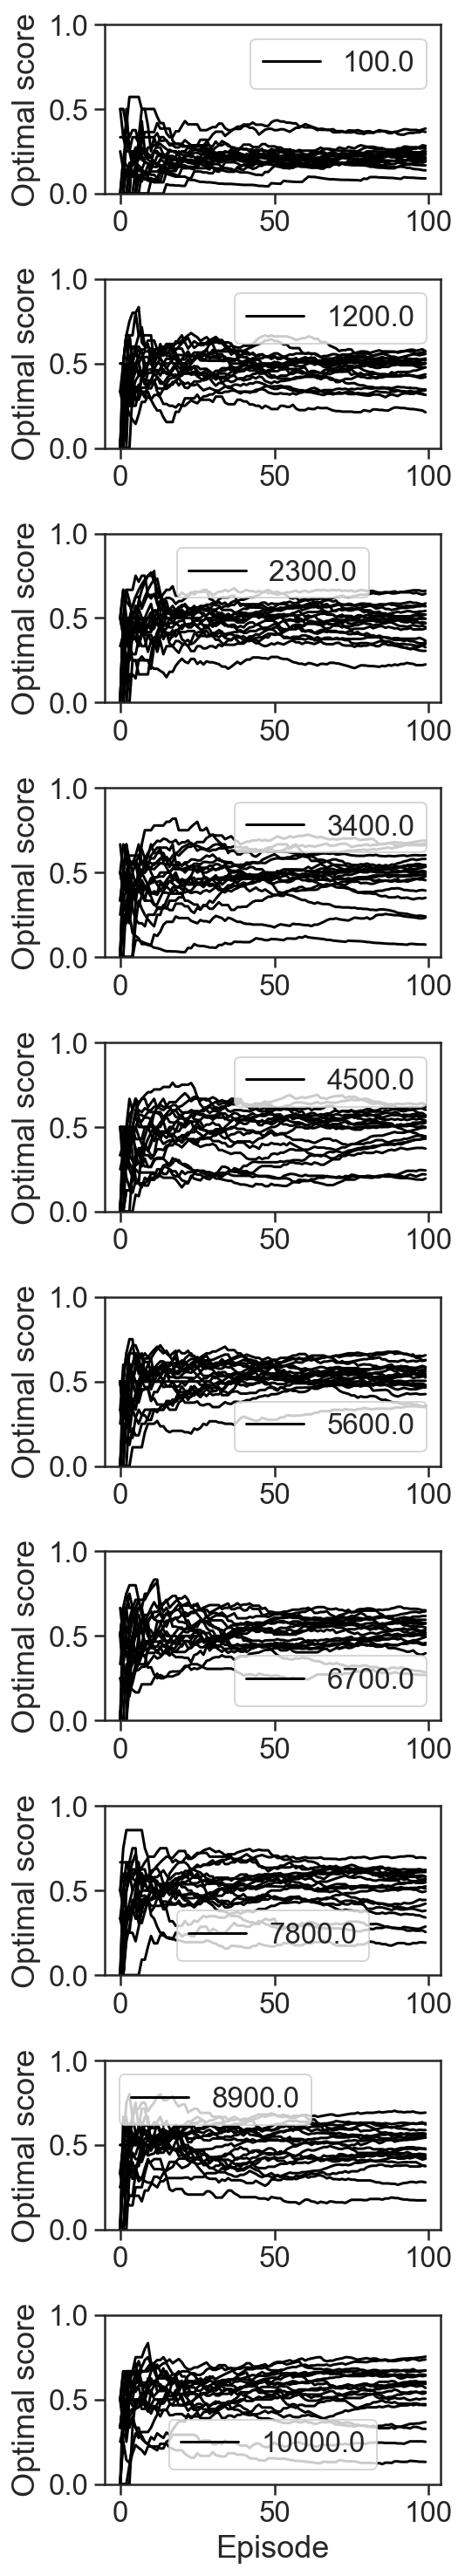

In [8]:
plt.figure(figsize=(4, 20.5))

sims = sorted(set(grid_42['num_simulations']))
for n, sim in enumerate(sims):
    plt.subplot(len(sims), 1, n+1)
    index = sim == np.asarray(grid_42['num_simulations'])
    index = np.arange(0,len(index))[index]
    first = True
    for r, mon in enumerate(exp_42):
        if r in index:
            if mon is not None:
                _ = plt.plot(mon['episode'], mon['score'], label=sim, color='black')
                _ = plt.ylim(0, 1)
                _ = plt.ylabel("Optimal score")
                _ = plt.tight_layout()
                if first:
                    plt.legend()
                    first = False
                                    
_ = plt.xlabel("Episode")

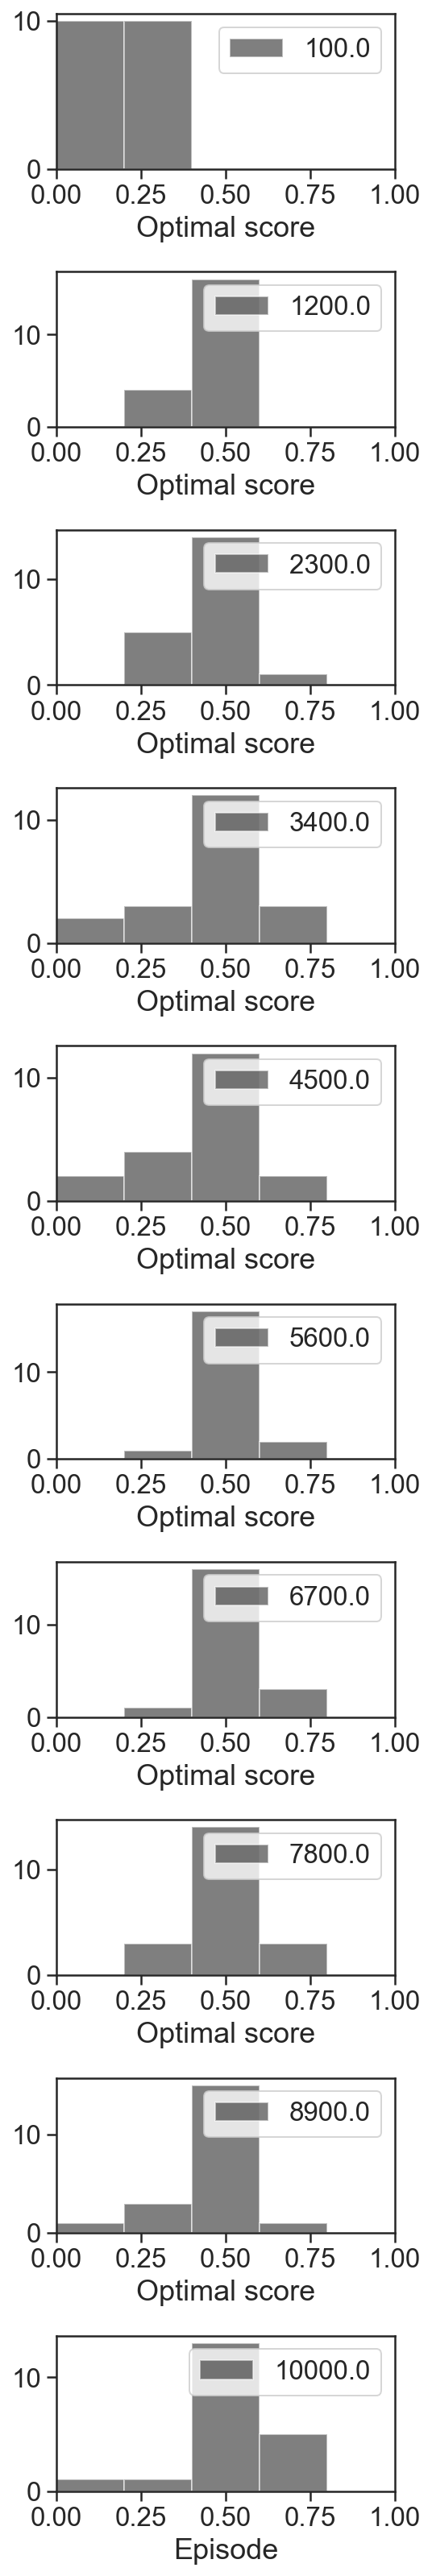

In [16]:
plt.figure(figsize=(4, 22.5))

sims = sorted(set(grid_42['num_simulations']))
for n, sim in enumerate(sims):
    plt.subplot(len(sims), 1, n+1)
    index = sim == np.asarray(grid_42['num_simulations'])
    index = np.arange(0,len(index))[index]
    first = True
    data = []
    for r, mon in enumerate(exp_42):
        if r in index:
            if mon is not None:
                data.append(np.mean(mon['score']))                
    _ = plt.hist(data, label=sim, alpha=0.5, color="black", bins=5, range=(0,1))        
    _ = plt.xlabel("Optimal score")
    _ = plt.xlim(0,1)
    _ = plt.tight_layout()
    plt.legend()
                                    
_ = plt.xlabel("Episode")

# Joint 

Plot ranked max scores DQN for HP sweep: `learning_rate` and `epsilon`.

No handles with labels found to put in legend.


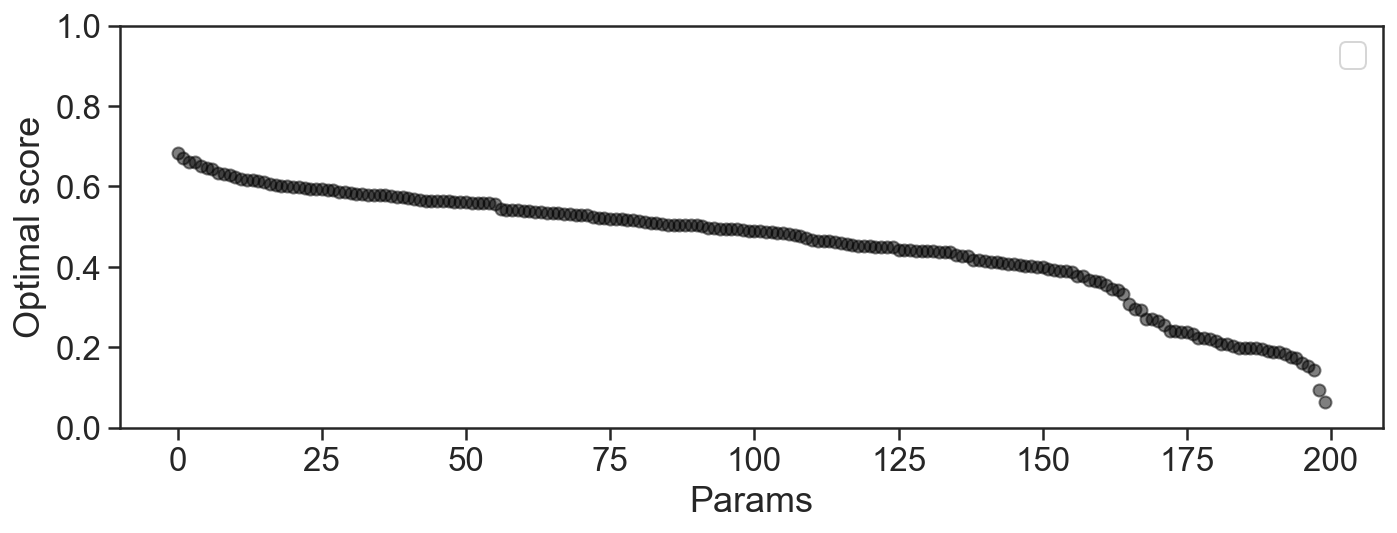

In [17]:
scores = []
for n, exp in enumerate(exp_42):
    if exp is not None:
        x = np.mean(exp['score'])
    else:
        x = 0
    scores.append(x)

scores = np.asarray(scores)
ranks = np.argsort(1 - scores).tolist()

plt.figure(figsize=(10, 4))
_ = plt.scatter(range(len(scores)), scores[ranks], alpha=0.5, color="black")        
_ = plt.ylabel("Optimal score")
_ = plt.xlabel("Params")
_ = plt.ylim(0,1)
_ = plt.tight_layout()
plt.legend()

Top 10:

In [18]:
pprint(("score", "c", "num_simulations"))
pprint([(scores[b], grid_42['c'][b], grid_42['num_simulations'][b]) for b in ranks[:10]])

('score', 'c', 'num_simulations')
[(0.6833844931002254, 2.035947, 10000.0),
 (0.6702262669929824, 1.911263, 3400.0),
 (0.6619186954539974, 1.661895, 10000.0),
 (0.6609490467727295, 0.539737, 7800.0),
 (0.6506558915425965, 1.537211, 4500.0),
 (0.6456229049251838, 1.287842, 7800.0),
 (0.6431414740224061, 0.664421, 3400.0),
 (0.6323124708415963, 1.038474, 7800.0),
 (0.6311875253810197, 0.789105, 10000.0),
 (0.6294058556256875, 1.911263, 6700.0)]
